# Inverse net (acc, speed -> pedal)

This network takes a 50 samples window of both speed (xsens1_gps_vel) and acceleration (xsens1) and returns a single output.
Negative values corresponds to absolute values of the pedal position while positive outputs are the accelerator position

In [1]:
# load libraries
import pandas as pd
import numpy as np
import pydot as pydot
import csv
import math
import os
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

Using MXNet backend


## load data

In [2]:
# set directory
os.chdir("dataCSV")
os.getcwd()

'/Users/riccardodona/ownCloud/H2020 Dreams4Cars (shared)/7. Data logs/DFKI vehicles/Riccardo Nets/dataCSV'

In [3]:
# load data
timeData = []
throttle = []
brake    = []
speed    = []
acc      = []

# Bassum
with open('dataNETBassum.csv', 'r') as csvfile:
    dataBassum = csv.reader(csvfile, delimiter=",")
    for row in dataBassum:
        timeData.append(float(row[0]))
        throttle.append(float(row[1]))
        brake.append(float(row[2]))
        speed.append(float(row[3]))
        acc.append(float(row[4]))

useJeddeloch = False        
# Jeddeloch 
if useJeddeloch == True:
    with open('dataNETJeddeloch.csv','r') as csvfile:
        dataJeddeloch = csv.reader(csvfile, delimiter=",")
        for row in dataJeddeloch:
            timeData.append(float(row[0]))
            throttle.append(float(row[1]))
            brake.append(float(row[2]))
            speed.append(float(row[3]))
            acc.append(float(row[4])) 

os.chdir("../")
os.getcwd()

In [4]:
# normalize data
accMax = max(map (abs, acc))
velMax = max(map (abs, speed))

acc    = np.array(acc)/accMax
speed  = np.array(speed)/velMax


In [7]:
# set net parameters
nAcc = 50; nVel = 50;


In [8]:
# arrange data
dataLen = len(throttle)
maxWin  = max([nAcc, nVel])

accInNet = np.empty((dataLen-maxWin,nAcc))
velInNet = np.empty((dataLen-maxWin,nVel))
ptOutNet = np.empty((dataLen-maxWin))
pbOutNet = np.empty((dataLen-maxWin))

for i in range(0,dataLen-maxWin):
    accInNet[i] = acc[i:i+nAcc]
    velInNet[i] = speed[i:i+nVel]
    ptOutNet[i] = throttle[i+maxWin]
    pbOutNet[i] = brake[i+maxWin]

In [9]:
# define train set
x_train = np.empty((dataLen-maxWin,nAcc+nVel))
for i in range(0,dataLen-maxWin):
    x_train[i] = np.array((acc[i:i+nAcc], speed[i:i+nVel])).flatten()

# define train set
y_train = np.empty((dataLen-maxWin))
for i in range(0,dataLen-maxWin):
    y_train[i] = np.array((ptOutNet[i]-pbOutNet[i]))


## Visualize data

In [10]:
# split examples
exList = []
j = 0
exList.append([0, 0])

for i in range(0, len(timeData)-1):
    if timeData[i]-timeData[i+1] < 0:
        exList[j][1] = i
    else:
        exList.append([i+1, 0])
        j += 1

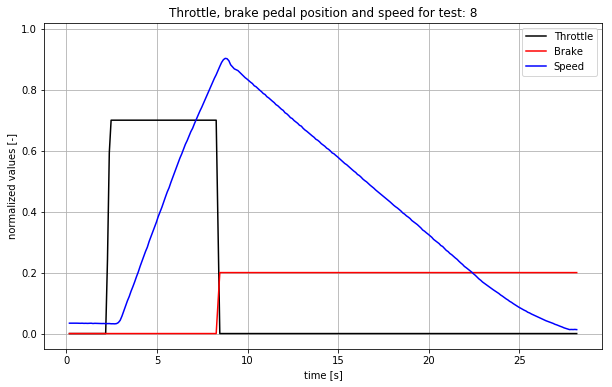

In [12]:
# inspect data
ex = 8

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(timeData[exList[ex][0]:exList[ex][1]],throttle[exList[ex][0]:exList[ex][1]],'-k')
plt.plot(timeData[exList[ex][0]:exList[ex][1]],brake[exList[ex][0]:exList[ex][1]],'-r')
plt.plot(timeData[exList[ex][0]:exList[ex][1]],speed[exList[ex][0]:exList[ex][1]],'-b')
plt.ylim([-0.05, 1.02])
plt.legend(['Throttle','Brake', 'Speed'])
plt.xlabel('time [s]')
plt.ylabel('normalized values [-]')
plt.title('Throttle, brake pedal position and speed for test: %d' % ex)
plt.show()


## Network structure

In [13]:
# test net
state_in = layers.Input(shape=(nAcc+nVel,),name='state_in')
lay1     = layers.Dense(50, activation='sigmoid')(state_in)
lay2     = layers.Dense(20, activation='relu')(lay1)
ped_out  = layers.Dense(1,name='pt_out',activation='tanh')(lay2)
invNet0  = models.Model(inputs=state_in, outputs=ped_out)

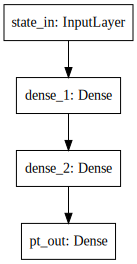

In [14]:
SVG(model_to_dot(invNet0).create(prog='dot', format='svg'))

In [16]:
# initialize model
invNet0.compile(loss='mse',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [17]:
# first train model
hist0 = invNet0.fit(x_train, y_train,
         epochs=200,
         batch_size=128,
         verbose=2);

Epoch 1/200
 - 0s - loss: 0.0858 - acc: 0.1631
Epoch 2/200


/anaconda/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0078125). Is this intended?
  force_init=force_init)


 - 0s - loss: 0.0557 - acc: 0.1671
Epoch 3/200
 - 0s - loss: 0.0484 - acc: 0.1673
Epoch 4/200
 - 0s - loss: 0.0421 - acc: 0.1676
Epoch 5/200
 - 0s - loss: 0.0373 - acc: 0.1682
Epoch 6/200
 - 0s - loss: 0.0326 - acc: 0.1682
Epoch 7/200
 - 0s - loss: 0.0311 - acc: 0.1682
Epoch 8/200
 - 0s - loss: 0.0280 - acc: 0.1686
Epoch 9/200
 - 0s - loss: 0.0262 - acc: 0.1686
Epoch 10/200
 - 0s - loss: 0.0252 - acc: 0.1688
Epoch 11/200
 - 0s - loss: 0.0231 - acc: 0.1690
Epoch 12/200
 - 0s - loss: 0.0235 - acc: 0.1690
Epoch 13/200
 - 0s - loss: 0.0220 - acc: 0.1688
Epoch 14/200
 - 0s - loss: 0.0217 - acc: 0.1690
Epoch 15/200
 - 0s - loss: 0.0213 - acc: 0.1690
Epoch 16/200
 - 0s - loss: 0.0214 - acc: 0.1688
Epoch 17/200
 - 0s - loss: 0.0206 - acc: 0.1690
Epoch 18/200
 - 0s - loss: 0.0211 - acc: 0.1690
Epoch 19/200
 - 0s - loss: 0.0206 - acc: 0.1691
Epoch 20/200
 - 0s - loss: 0.0203 - acc: 0.1691
Epoch 21/200
 - 0s - loss: 0.0204 - acc: 0.1690
Epoch 22/200
 - 0s - loss: 0.0200 - acc: 0.1690
Epoch 23/200

Epoch 172/200
 - 0s - loss: 0.0118 - acc: 0.1692
Epoch 173/200
 - 0s - loss: 0.0117 - acc: 0.1693
Epoch 174/200
 - 0s - loss: 0.0118 - acc: 0.1693
Epoch 175/200
 - 0s - loss: 0.0115 - acc: 0.1692
Epoch 176/200
 - 0s - loss: 0.0120 - acc: 0.1691
Epoch 177/200
 - 0s - loss: 0.0115 - acc: 0.1690
Epoch 178/200
 - 0s - loss: 0.0116 - acc: 0.1693
Epoch 179/200
 - 0s - loss: 0.0117 - acc: 0.1693
Epoch 180/200
 - 0s - loss: 0.0115 - acc: 0.1693
Epoch 181/200
 - 0s - loss: 0.0119 - acc: 0.1696
Epoch 182/200
 - 0s - loss: 0.0113 - acc: 0.1692
Epoch 183/200
 - 0s - loss: 0.0115 - acc: 0.1693
Epoch 184/200
 - 0s - loss: 0.0116 - acc: 0.1691
Epoch 185/200
 - 0s - loss: 0.0113 - acc: 0.1693
Epoch 186/200
 - 0s - loss: 0.0116 - acc: 0.1695
Epoch 187/200
 - 0s - loss: 0.0116 - acc: 0.1693
Epoch 188/200
 - 0s - loss: 0.0114 - acc: 0.1692
Epoch 189/200
 - 0s - loss: 0.0116 - acc: 0.1691
Epoch 190/200
 - 0s - loss: 0.0114 - acc: 0.1696
Epoch 191/200
 - 0s - loss: 0.0112 - acc: 0.1696
Epoch 192/200
 - 0s 

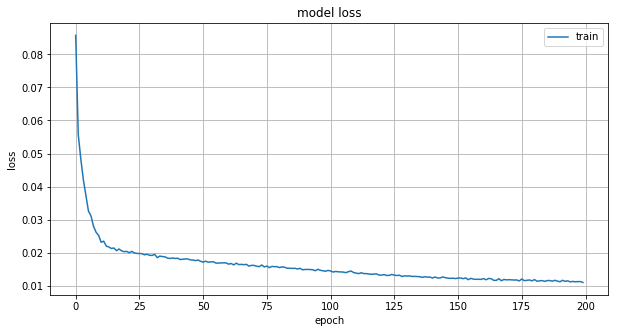

In [18]:
plt.figure(figsize=(10,5))
plt.plot(hist0.history['loss'])
plt.grid()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [25]:
# second train model
hist1 = invNet0.fit(x_train, y_train,
         epochs=100,
         batch_size=32,
         verbose=2);

Epoch 1/100
 - 0s - loss: 0.0056 - acc: 0.1699
Epoch 2/100
 - 0s - loss: 0.0057 - acc: 0.1699
Epoch 3/100
 - 0s - loss: 0.0055 - acc: 0.1697
Epoch 4/100
 - 0s - loss: 0.0055 - acc: 0.1699
Epoch 5/100
 - 0s - loss: 0.0055 - acc: 0.1700
Epoch 6/100
 - 0s - loss: 0.0056 - acc: 0.1697
Epoch 7/100
 - 0s - loss: 0.0056 - acc: 0.1697
Epoch 8/100
 - 0s - loss: 0.0058 - acc: 0.1699
Epoch 9/100
 - 0s - loss: 0.0055 - acc: 0.1699
Epoch 10/100
 - 0s - loss: 0.0057 - acc: 0.1695
Epoch 11/100
 - 0s - loss: 0.0057 - acc: 0.1696
Epoch 12/100
 - 0s - loss: 0.0056 - acc: 0.1699
Epoch 13/100
 - 0s - loss: 0.0057 - acc: 0.1697
Epoch 14/100
 - 0s - loss: 0.0055 - acc: 0.1699
Epoch 15/100
 - 0s - loss: 0.0055 - acc: 0.1697
Epoch 16/100
 - 0s - loss: 0.0054 - acc: 0.1699
Epoch 17/100
 - 0s - loss: 0.0055 - acc: 0.1699
Epoch 18/100
 - 1s - loss: 0.0055 - acc: 0.1697
Epoch 19/100
 - 0s - loss: 0.0055 - acc: 0.1697
Epoch 20/100
 - 0s - loss: 0.0054 - acc: 0.1697
Epoch 21/100
 - 0s - loss: 0.0054 - acc: 0.1699
E

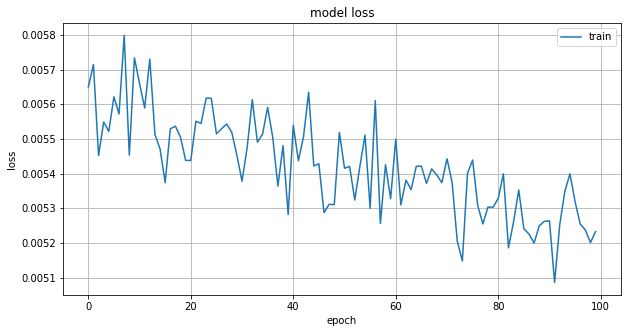

In [26]:
plt.figure(figsize=(10,5))
plt.plot(hist1.history['loss'])
plt.grid()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Inspect results

In [27]:
outPedalNet = invNet0.predict(x_train)


In [28]:
ptPredNet = np.empty((len(outPedalNet)))
pbPredNet = np.empty((len(outPedalNet)))

for i in range(0,len(outPedalNet)):
    ptPredNet[i] = max(0, outPedalNet[i])
    pbPredNet[i] = -min(0, outPedalNet[i])
    

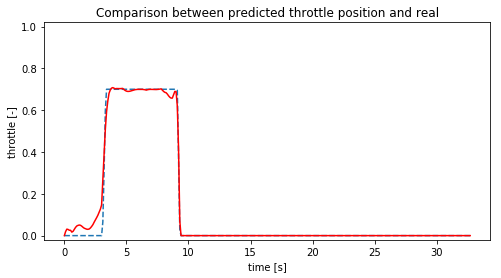

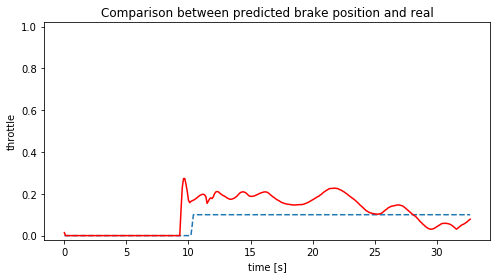

In [162]:
ex = 5

plt.figure(figsize=(8,4))
plt.plot(timeData[exList[ex][0]:exList[ex][1]], throttle[exList[ex][0]:exList[ex][1]],'--')
plt.plot(timeData[exList[ex][0]:exList[ex][1]], ptPredNet[exList[ex][0]-maxWin:exList[ex][1]-maxWin],'r-')
plt.ylim((-0.02,1.02))
plt.xlabel('time [s]')
plt.ylabel('throttle [-]')
plt.title('Comparison between predicted throttle position and real')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(timeData[exList[ex][0]:exList[ex][1]], brake[exList[ex][0]:exList[ex][1]],'--')
plt.plot(timeData[exList[ex][0]:exList[ex][1]], pbPredNet[exList[ex][0]-maxWin:exList[ex][1]-maxWin],'r-')
plt.ylim((-0.02,1.02))
plt.xlabel('time [s]')
plt.ylabel('throttle')
plt.title('Comparison between predicted brake position and real')
plt.show()

# Export model

In [32]:
from keras import backend as K
backend = K.backend()
print(backend)

mxnet


In [188]:
if backend == 'tensorflow':
    # export model to hdf5 file
    invNet1.save('outNet/invNet0.h5')
    jsonInvNet1 = invNet1.to_json()
    with open("outNet/invNet0_tf.json","w") as json_file:
        json_file.write(jsonInvNet1)
elif backend == 'mxnet':
    from keras.models import save_mxnet_model
    os.chdir("outNet")
    data_names, data_shapes = save_mxnet_model(model=invNet0, 
                                           prefix='invNet0',
                                           epoch=0)
    os.chdir("../")

MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  invNet0-symbol.json
MXNet params file -  invNet0-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/state_in1']
data_shapes :  [DataDesc[/state_in1,(1, 100),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.


## Test network

In [210]:
# create fake data set
xtest = np.zeros((1,100))
xtest[0][0:-1] = 0.01

In [211]:
# in kernel network prediction
invNet0.predict(xtest)

array([[0.07710256]], dtype=float32)

In [185]:
# load trained net 
os.chdir("outNet")
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='invNet0', epoch=0)

os.chdir("../")

In [139]:
# assign weights
loadInvNet0 = mx.module.Module(symbol=sym, 
                    data_names=['/state_in1'], 
                    context=mx.cpu(), 
                    label_names=None)

In [140]:
# define input
loadInvNet0.bind(for_training=False, 
         data_shapes=[('/state_in1', (1,100))])

loadInvNet0.set_params(arg_params, aux_params, allow_missing=True)

In [141]:
xtestLoad = mx.io.NDArrayIter(xtest, None, 1)
loadInvNet0.predict(xtestLoad)


[[-0.8424833]]
<NDArray 1x1 @cpu(0)>

In [144]:
def compareNets(xT):
    outTrainNet  = invNet0.predict(xT)[0][0]
    xtestLoadFun = mx.io.NDArrayIter(xT, None, 1)
    outLoadNet   = (loadInvNet0.predict(xtestLoadFun)[0]).asnumpy()[0]
    print('Output trained net:',outTrainNet)
    print('Output loaded  net:',outLoadNet)

In [217]:
xtestFun = np.zeros((1,100))
xtestFun[0][0:-1] = 0.5

compareNets(xtestFun)

Output trained net: 0.7029929
Output loaded  net: 0.7029929


In [199]:
# export fixed net for MXNet C++ loading
fix_arg_params = {}
for i, key in enumerate(arg_params):
    fix_arg_params['arg:'+key]=arg_params[key]

mx.nd.save("outNet/invNet0-0000.params",fix_arg_params)